In [122]:

import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings("ignore")

# hv.renderer('bokeh').theme = 'dark_minimal'


# Data Loading
It is always a good advice to use standard formats to transfer data from one computer to another. One of the most used formats is parquet. The following code should help you to load the data into your python environment.

In [87]:
# dataset_root = Path(r"C:\Users\Turquin\Documents\MLFPMA - Machine Learning for Predictive Maintenance Application\Project\Dataset") # Raw string works without escaping \
dataset_root = Path("./Dataset")

@dataclass
class Case():
    info: pd.DataFrame
    measurements: pd.DataFrame


class RawDataset():
    def __init__(self, root, unit = "VG4", load_training=False, load_synthetic=False, load_anomalies=False) -> None:
        read_pq_file = lambda f: pq.read_table(root / f).to_pandas()
        
        cases = {
            "test": [f"{unit}_generator_data_testing_real_measurements.parquet", root / f"{unit}_generator_data_testing_real_info.csv" ], 
        }

        if load_training:
            cases = {
                **cases,
                "train": [f"{unit}_generator_data_training_measurements.parquet", root / f"{unit}_generator_data_training_info.csv" ], 
            }

        if load_synthetic:
            cases = {
                **cases,
                "test_s01": [f"{unit}_generator_data_testing_synthetic_01_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_01_info.csv"], 
                "test_s02": [f"{unit}_generator_data_testing_synthetic_02_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_02_info.csv"]
            }

        if load_anomalies:
            anomaly_folder = Path("synthetic_anomalies")  # Relative path
            subdataset = ["01", "02"]
            anomaly_types = ["a", "b", "c"]
            for anomaly in subdataset:
                for subtype in anomaly_types:
                    anomaly_key = f"anomaly_{anomaly}_type_{subtype}"
                    anomaly_file = f"{unit}_anomaly_{anomaly}_type_{subtype}.parquet"
                    full_anomaly_path = root / anomaly_folder / anomaly_file
                    if full_anomaly_path.exists():
                        cases[anomaly_key] = [anomaly_folder / anomaly_file, None]

        
        self.data_dict = dict()
        
        for id_c, c in cases.items():
            # if you need to verify the parquet header:
            # pq_rows = RawDataset.read_parquet_schema_df(root / c[0])
            measurements = read_pq_file(c[0])
            info = pd.read_csv(c[1]) if c[1] is not None else None
            self.data_dict[id_c] = Case(info, measurements)
    
    @staticmethod
    def read_parquet_schema_df(uri: str) -> pd.DataFrame:
        """Return a Pandas dataframe corresponding to the schema of a local URI of a parquet file.

        The returned dataframe has the columns: column, pa_dtype
        """
        # Ref: https://stackoverflow.com/a/64288036/
        schema = pq.read_schema(uri, memory_map=True)
        schema = pd.DataFrame(({"column": name, "pa_dtype": str(pa_dtype)} for name, pa_dtype in zip(schema.names, schema.types)))
        schema = schema.reindex(columns=["column", "pa_dtype"], fill_value=pd.NA)  # Ensures columns in case the parquet file has an empty dataframe.
        return schema
    

rds_u4 = RawDataset(dataset_root, "VG4", load_synthetic=False, load_training=True)
rds_u5 = RawDataset(dataset_root, "VG5", load_synthetic=True, load_training=True, load_anomalies=True)
rds_u6 = RawDataset(dataset_root, "VG6", load_synthetic=True, load_anomalies=True)

# Operation Modes

As you can see, the operation modes (at the very bottom) are not in the info schema, but you can find them when you explore the parquet schema (metadata of the parquet data file).

In [82]:
RawDataset.read_parquet_schema_df(dataset_root / "VG4_generator_data_testing_real_measurements.parquet")

,column,pa_dtype
0,tot_activepower,double
1,plant_tmp,double
2,ext_tmp,double
3,water_primary_cold_tmp,double
4,water_primary_hot_tmp,double
5,valve_opening,double
6,refri_bath_level,double
7,aspi_bath_level,double
8,canal_level,double
9,canal_tmp,double


We can use `head()` to glance at the data.

In [14]:
rds_u4.data_dict["train"].info.head()

,Unnamed: 0,signal_name,attribute_name,asset,unit,element,signal_type,control_signal,input_feature,output_feature,core_attribute
0,0,FMHL_SUP_VEY.MHL_VG4_G4_P,tot_activepower,Veytaux 1,VG4,Generator,Measurement,False,True,True,False
1,1,FMHL_SUP_VEY.MHL_VGE_PRAP_TEMP_USINE,plant_tmp,Veytaux 1,General,Plant,Measurement,False,False,True,False
2,2,FMHL_SUP_VEY.MHL_V2_EAU0_TEMP_EXT,ext_tmp,Veytaux 1,General,Plant,Measurement,False,False,True,False
3,3,FMHL_SUP_VEY.MHL_VGE_PRAP_CLI_TEMP_DEP,water_primary_cold_tmp,Veytaux 1,General,Cooling,Measurement,False,False,True,False
4,4,FMHL_SUP_VEY.MHL_VGE_PRAP_CLI_TEMP_RET,water_primary_hot_tmp,Veytaux 1,General,Cooling,Measurement,False,False,True,False


In [15]:
rds_u4.data_dict["train"].measurements.head()

,tot_activepower,plant_tmp,ext_tmp,water_primary_cold_tmp,water_primary_hot_tmp,valve_opening,refri_bath_level,aspi_bath_level,canal_level,canal_tmp,...,water_circ_hot_02_tmp,water_circ_cold_tmp,machine_on,machine_off,turbine_mode,all,equilibrium_turbine_mode,dyn_only_on,pump_mode,equilibrium_pump_mode
2020-01-02 00:00:00+01:00,-39.830002,16.516650,5.961580,10.90,12.826471,99.875000,2.956812,5.932592,371.846035,9.000000,...,16.882689,12.220884,True,False,False,True,False,True,False,False
2020-01-02 00:00:30+01:00,-62.433334,16.554980,5.992895,10.85,12.914706,99.873437,2.955667,5.927700,371.836559,8.912023,...,16.797366,12.095122,True,False,False,True,False,True,True,True
2020-01-02 00:01:00+01:00,-62.571904,16.593311,6.024210,10.80,13.002564,99.871875,2.960449,5.922808,371.711225,8.824047,...,16.712043,11.969360,True,False,False,True,False,True,True,True
2020-01-02 00:01:30+01:00,-62.507894,16.631641,6.055526,10.85,13.079487,99.870312,2.968310,5.917917,371.765866,8.736070,...,16.626720,11.825357,True,False,False,True,False,True,True,True
2020-01-02 00:02:00+01:00,-62.397368,16.669971,6.086841,10.90,13.126829,99.868750,2.979270,5.913025,371.842773,8.648094,...,16.369280,11.608393,True,False,False,True,False,True,True,True


# Data Exploration
- Make sure that you explore the data in detail. For example, we will see that there is quite a big gap in operation from train to test if we look at the injector pressures of unit 4.
- To not overload our machine when plotting, we can use an index selection trick to downsample the data (since the dataframes are quite large) `[::100]`.
    - Please be aware that this is just to get some insights, we are only plotting every 100th step.

In [16]:
rds_u5.data_dict["train"].info

,Unnamed: 0,signal_name,attribute_name,asset,unit,element,signal_type,control_signal,input_feature,output_feature,core_attribute
0,0,FMHL_SUP_VEY.MHL_VG5_reEDSMT_P_MW,tot_activepower,Veytaux 2,VG5,Generator,Measurement,False,True,True,False
1,1,FMHL_SUP_VEY.MHL_V2_EAU0_TEMP_EXT,ext_tmp,Veytaux 2,General,Plant,Measurement,False,False,True,False
2,2,FMHL_SUP_VEY.MHL_V2_EAU0_TEMP_USINE,plant_tmp,Veytaux 2,General,Plant,Measurement,False,False,True,False
3,3,FMHL_SUP_VEY.MHL_VG5_reMTU_CC_GT,charge,Veytaux 2,VG5,Turbine,Measurement,True,False,True,False
4,4,FMHL_SUP_VEY.MHL_VG5_reMGP6_CPL_GT,coupler_position,Veytaux 2,VG5,Coupler,Measurement,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
86,86,FMHL_SUP_VEY.MHL_VG5_MPM1_AIR_GAP_XP,air_gap_positive_x_position,Veytaux 2,VG5,Generator,Measurement,False,False,True,False
87,87,FMHL_SUP_VEY.MHL_VG5_MPM1_AIR_GAP_YM,air_gap_negative_y_position,Veytaux 2,VG5,Generator,Measurement,False,False,True,False
88,88,FMHL_SUP_VEY.MHL_VG5_MPM1_AIR_GAP_YP,air_gap_positive_y_position,Veytaux 2,VG5,Generator,Measurement,False,False,True,False
89,89,FEAT.Veytaux_2.VG5.Control.Control_Feature.tim...,timer_turbine_on_off,Veytaux 2,VG5,Control,Feature,True,False,False,False


There are quite many signals, so it makes sense to study them in groups. Here we focus on the temperatures `_tmp`), but you are supposed to look at all the other signals as well of course!

In [17]:
df = rds_u4.data_dict["train"].info
temperature_attrs = df[df.attribute_name.str.endswith("_tmp")]
temperature_attrs

,Unnamed: 0,signal_name,attribute_name,asset,unit,element,signal_type,control_signal,input_feature,output_feature,core_attribute
1,1,FMHL_SUP_VEY.MHL_VGE_PRAP_TEMP_USINE,plant_tmp,Veytaux 1,General,Plant,Measurement,False,False,True,False
2,2,FMHL_SUP_VEY.MHL_V2_EAU0_TEMP_EXT,ext_tmp,Veytaux 1,General,Plant,Measurement,False,False,True,False
3,3,FMHL_SUP_VEY.MHL_VGE_PRAP_CLI_TEMP_DEP,water_primary_cold_tmp,Veytaux 1,General,Cooling,Measurement,False,False,True,False
4,4,FMHL_SUP_VEY.MHL_VGE_PRAP_CLI_TEMP_RET,water_primary_hot_tmp,Veytaux 1,General,Cooling,Measurement,False,False,True,False
9,9,FMHL_SUP_VEY.MHL_VGA_PRAP_TEMP_CAN_FUITE,canal_tmp,Veytaux 1,General,Cooling,Measurement,False,False,True,False
12,12,FMHL_SUP_VEY.MHL_VGE_CLI_TEMP_EAU,lake_tmp,Veytaux 1,General,Cooling,Measurement,False,False,True,False
37,37,FMHL_SUP_VEY.MHL_VG4_PRAP_ME_TEMP_AIC,air_circ_hot_tmp,Veytaux 1,VG4,Generator,Measurement,False,False,True,False
38,38,FMHL_SUP_VEY.MHL_VG4_PRAP_ME_TEMP_AIF_AMO,air_circ_cold_01_tmp,Veytaux 1,VG4,Generator,Measurement,False,False,True,False
39,39,FMHL_SUP_VEY.MHL_VG4_PRAP_ME_TEMP_AIF_AVA,air_circ_cold_02_tmp,Veytaux 1,VG4,Generator,Measurement,False,False,True,False
40,40,FMHL_SUP_VEY.MHL_VG4_PRAP_STAT_TEMP_FER,stat_magn_01_tmp,Veytaux 1,VG4,Generator,Measurement,False,False,True,False


We can use pandas to directly plot the data. Usually, panda uses matplotlib, but when we install the hvplot module, we can have a much nicer html data explorer.

<Axes: >

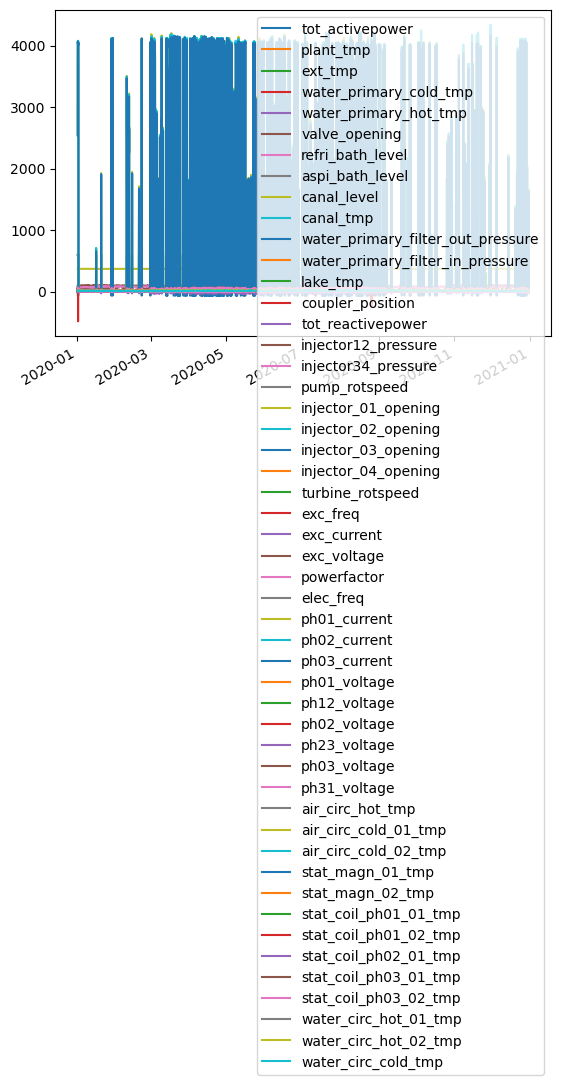

In [18]:
rds_u4.data_dict["train"].measurements[::100].plot()

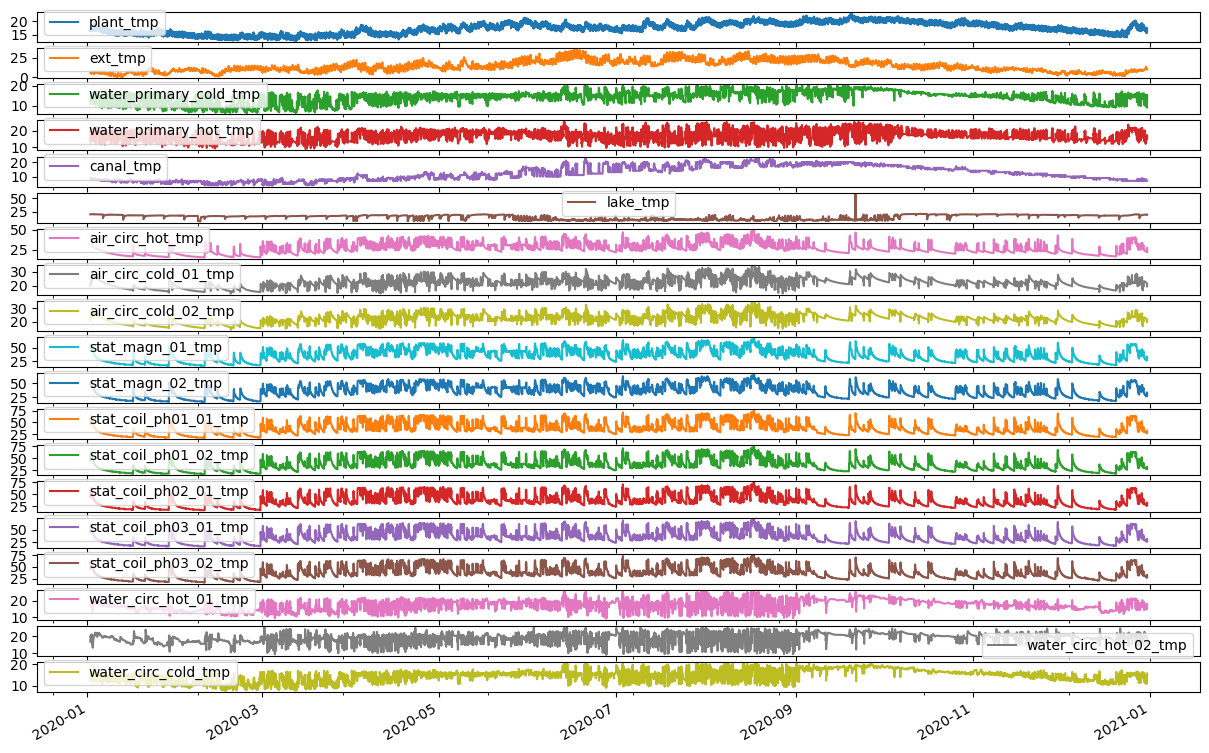

In [19]:

temperature_columns = temperature_attrs.attribute_name.values
rds_u4.data_dict["train"].measurements[::100][temperature_columns].plot(subplots=True, figsize=(15, 10))
plt.show()

An other example would be to look at injector pressures:

In [20]:
df = rds_u4.data_dict["train"].info
temperature_attrs = df[df.attribute_name.str.contains("injector")]
temperature_attrs

,Unnamed: 0,signal_name,attribute_name,asset,unit,element,signal_type,control_signal,input_feature,output_feature,core_attribute
15,15,FMHL_SUP_VEY.MHL_VG4_PRMTU_PRES_EAU_PT12,injector12_pressure,Veytaux 1,VG4,MIV1,Measurement,True,False,True,False
16,16,FMHL_SUP_VEY.MHL_VG4_PRMTU_PRES_EAU_PT34,injector34_pressure,Veytaux 1,VG4,MIV2,Measurement,True,False,True,False
18,18,FMHL_SUP_VEY.MHL_VG4_MIPMTU_PT1_OUVERTURE,injector_01_opening,Veytaux 1,VG4,Turbine,Measurement,True,False,True,False
19,19,FMHL_SUP_VEY.MHL_VG4_MIPMTU_PT2_OUVERTURE,injector_02_opening,Veytaux 1,VG4,Turbine,Measurement,True,False,True,False
20,20,FMHL_SUP_VEY.MHL_VG4_MIPMTU_PT3_OUVERTURE,injector_03_opening,Veytaux 1,VG4,Turbine,Measurement,True,False,True,False
21,21,FMHL_SUP_VEY.MHL_VG4_MIPMTU_PT4_OUVERTURE,injector_04_opening,Veytaux 1,VG4,Turbine,Measurement,True,False,True,False
50,50,FEAT.Veytaux_1.VG4.Control.Control_Feature.tim...,timer_injector_opening,Veytaux 1,VG4,Control,Feature,True,False,False,False


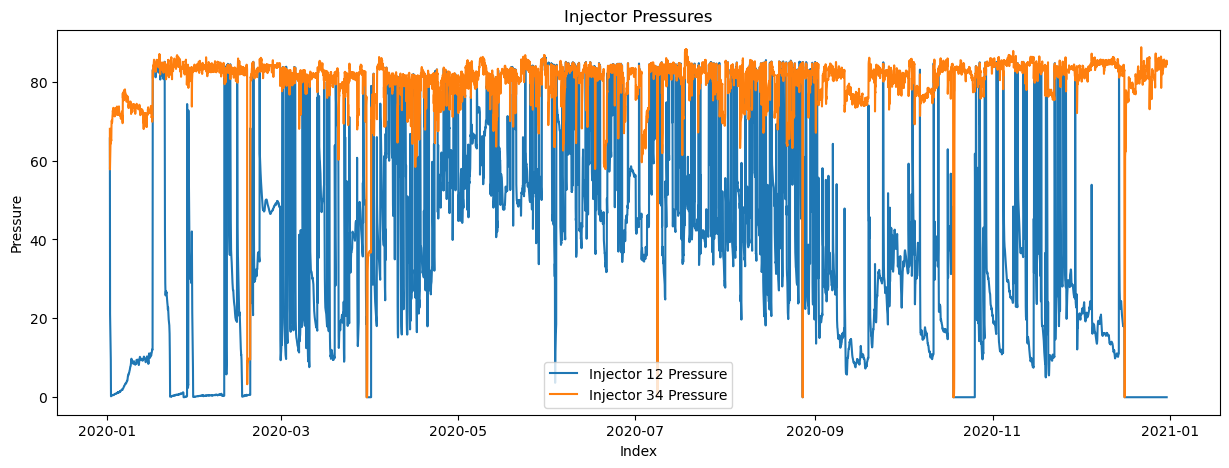

In [21]:
# Plotting the injector pressures
plt.figure(figsize=(15, 5))
plt.plot(rds_u4.data_dict["train"].measurements[::100]["injector12_pressure"], label="Injector 12 Pressure")
plt.plot(rds_u4.data_dict["train"].measurements[::100]["injector34_pressure"], label="Injector 34 Pressure")
plt.xlabel("Index")
plt.ylabel("Pressure")
plt.title("Injector Pressures")
plt.legend()
plt.show()

As you can see, the test set is quite short compared to the training set. For injector 1, the test distribution is different compared to the training distribution (distribution shift).
Be aware that such distribution shifts can greatly influence the performance of your model.

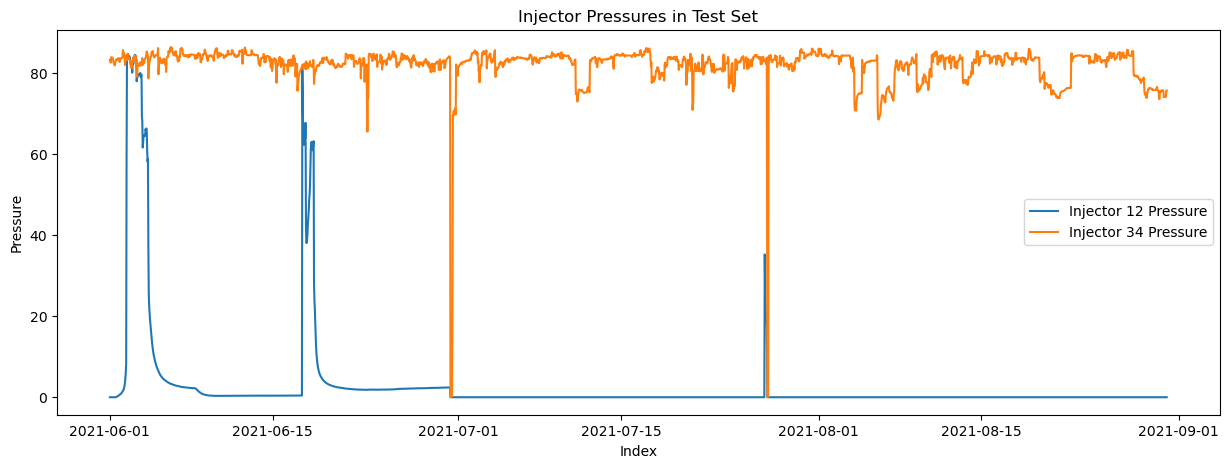

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(rds_u4.data_dict["test"].measurements[::100]["injector12_pressure"], label="Injector 12 Pressure")
plt.plot(rds_u4.data_dict["test"].measurements[::100]["injector34_pressure"], label="Injector 34 Pressure")
plt.xlabel("Index")
plt.ylabel("Pressure")
plt.title("Injector Pressures in Test Set")
plt.legend()
plt.show()

We can also explore the machines in operation next to each other:

The training data sets.

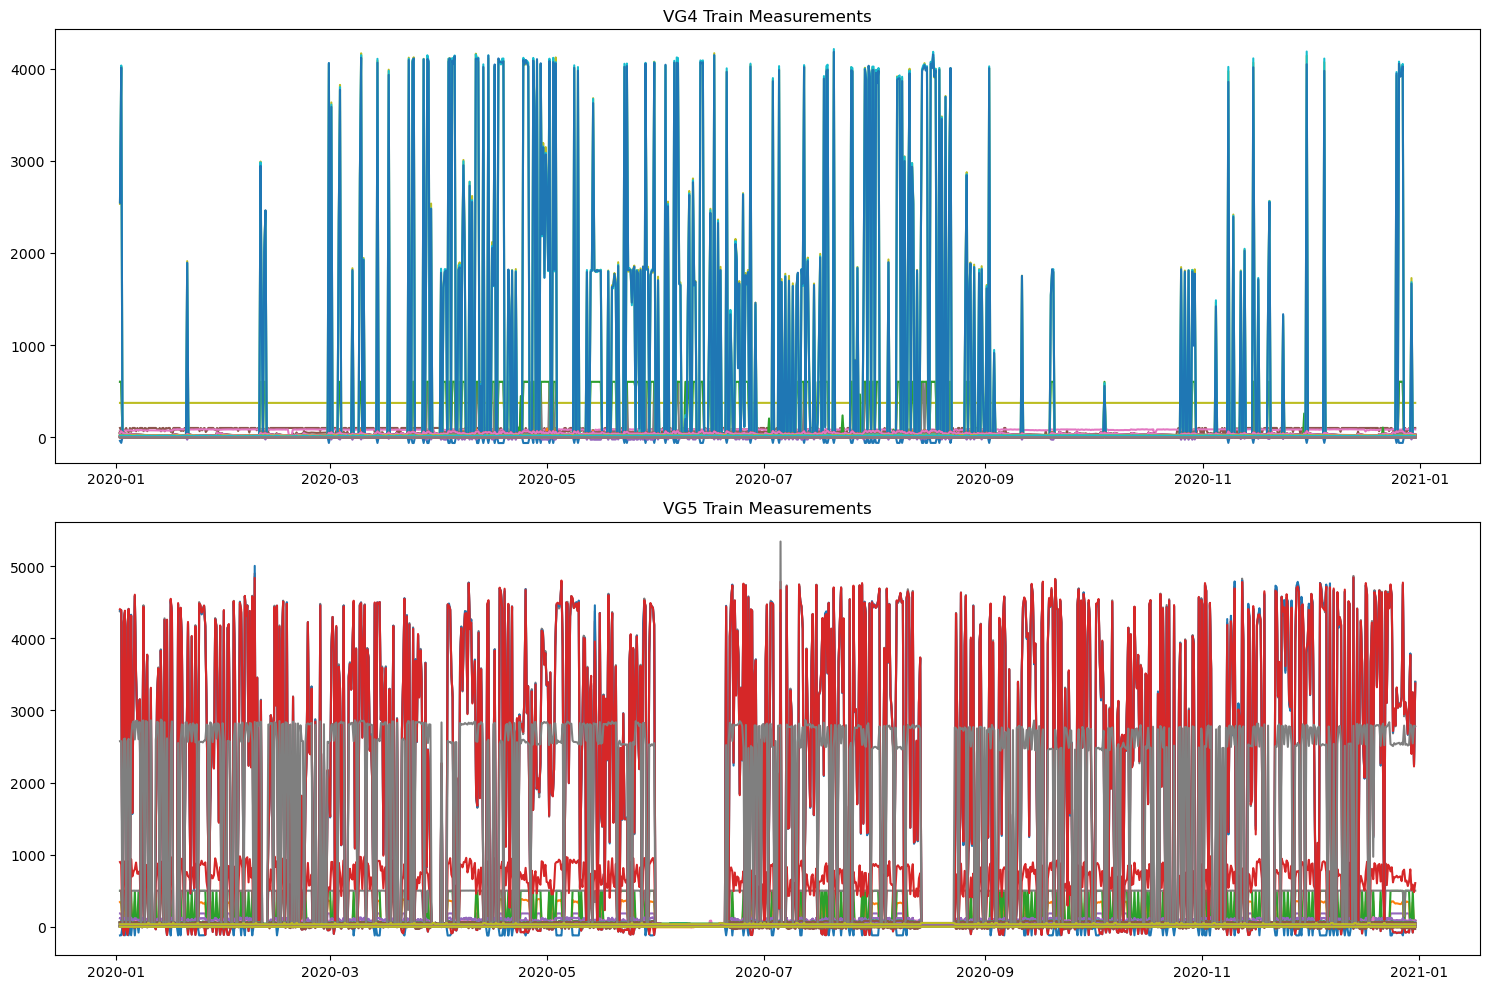

In [23]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(rds_u4.data_dict["train"].measurements[::1000])
plt.title("VG4 Train Measurements")

plt.subplot(2, 1, 2)
plt.plot(rds_u5.data_dict["train"].measurements[::1000])
plt.title("VG5 Train Measurements")

plt.tight_layout()
plt.show()

We see that the test datasets are recorded troughout different seasons, which can have an impact on the recorded data.

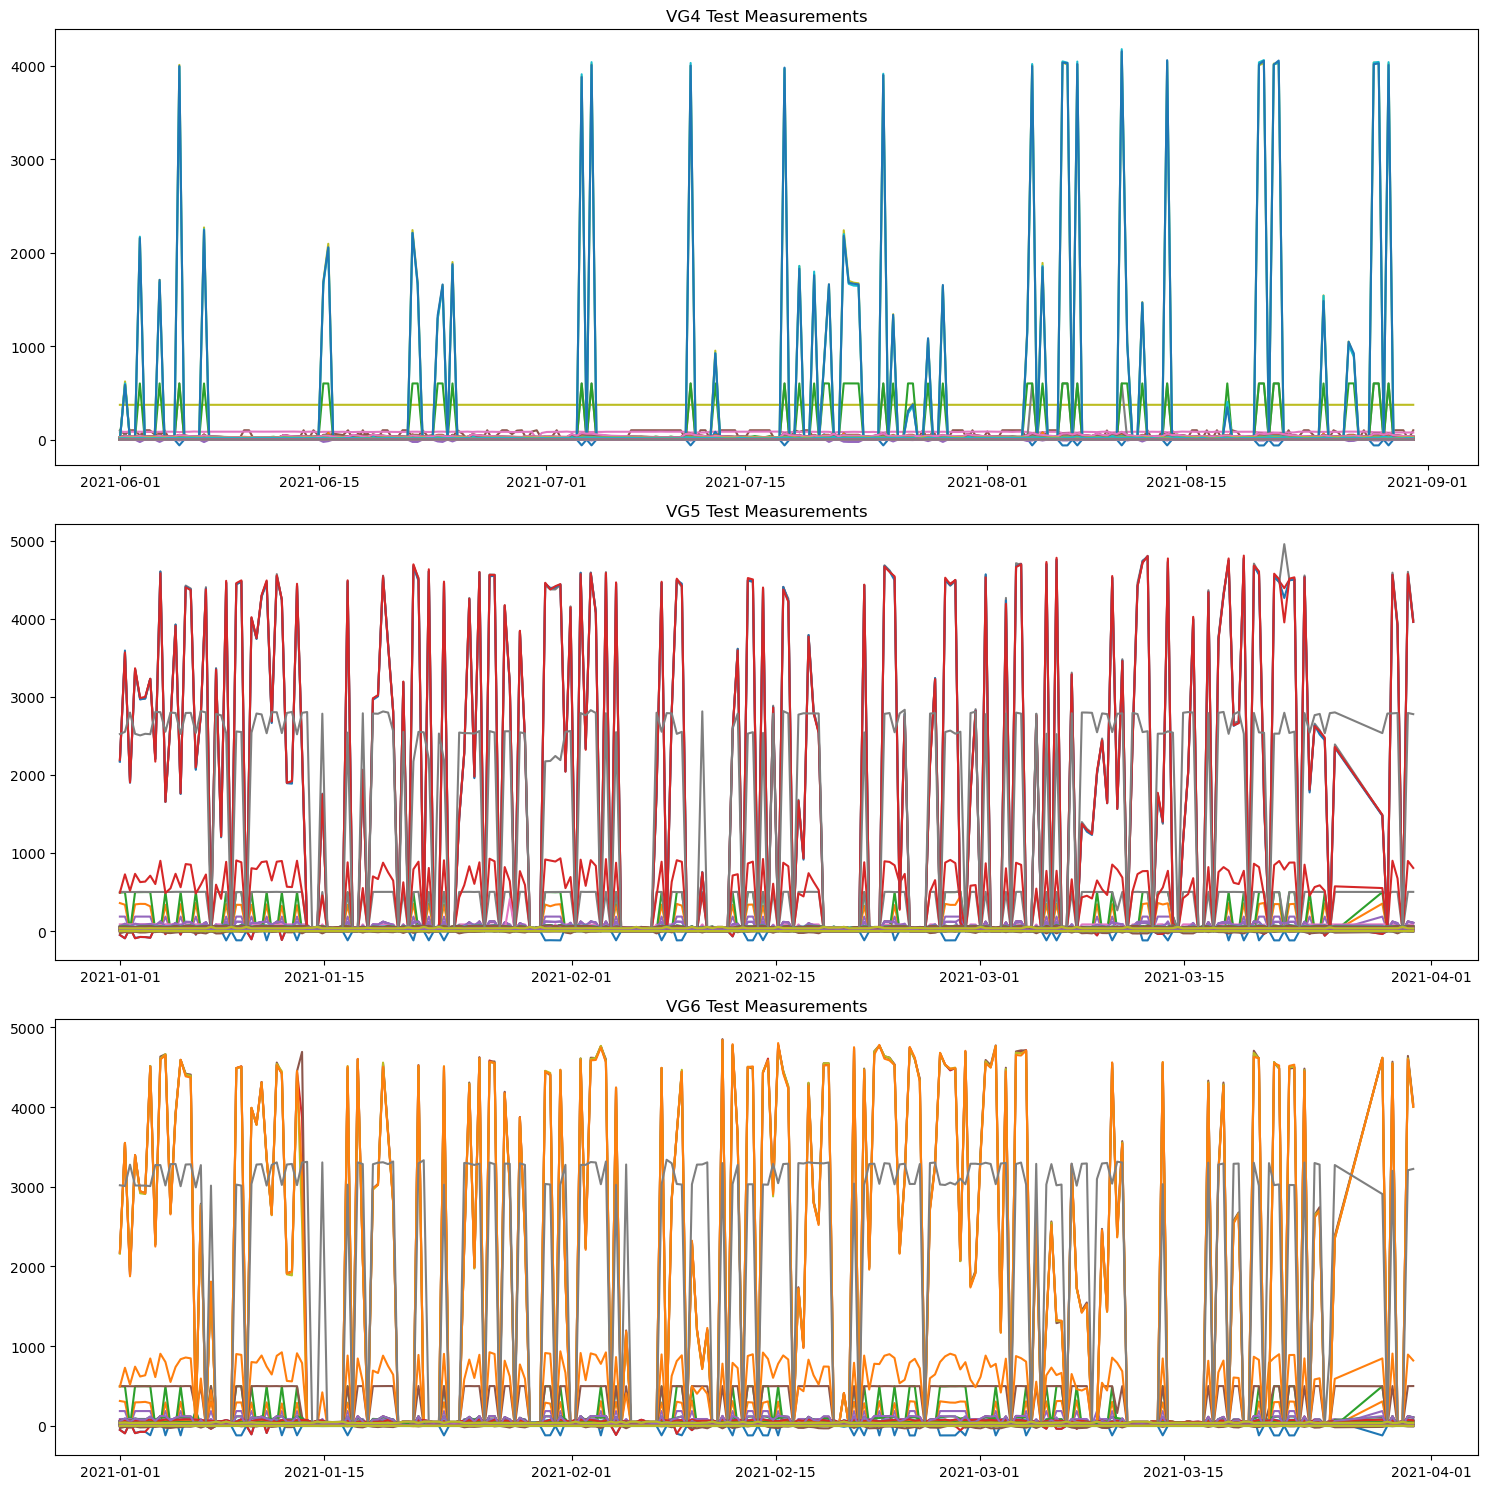

In [24]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
plt.plot(rds_u4.data_dict["test"].measurements[::1000])
plt.title("VG4 Test Measurements")

plt.subplot(3, 1, 2)
plt.plot(rds_u5.data_dict["test"].measurements[::1000])
plt.title("VG5 Test Measurements")

plt.subplot(3, 1, 3)
plt.plot(rds_u6.data_dict["test"].measurements[::1000])
plt.title("VG6 Test Measurements")

plt.tight_layout()
plt.show()

Now it's your turn. Try to explore the data as much as possible before engineering the solution. The main difficulty in real-world problems often isn't the complexity, but understanding the actual problem you are trying to solve, as there is no "guidance" like in the exercises you saw throughout this class. Remember, there are always trade-offs when selecting a model which you should evaluate before investing a lot of time on the implementation.

## My Turn : 

I want to work only with VG5, because I'm lazy :

First : compute abs. value :

In [25]:
# Compute absolute values for train and test data sets of VG5
rds_u5.data_dict["train"].measurements = rds_u5.data_dict["train"].measurements.abs()
rds_u5.data_dict["test"].measurements = rds_u5.data_dict["test"].measurements.abs()


Compute Min, Max, Centered Moments and Centralized Moments : 
 NOTE : IT'S downsampled likebefore (1/100) otherwised it takes hours

In [26]:
# # Compute Min, Max, Centered Moments and Centralized Moments for VG5 train and test datasets
# def compute_statistics(df):
#     stats = pd.DataFrame(index=df.columns)
#     stats['min'] = df.min()
#     stats['max'] = df.max()
#     stats['mean'] = df.mean()
#     stats['std'] = df.std()
#     centered_moment = df.sub(stats['mean'], axis=1)
#     centralized_moment = centered_moment.div(stats['std'], axis=1)
#     for col in df.columns:
#         stats[f'centered_moment_{col}'] = centered_moment[col]
#         stats[f'centralized_moment_{col}'] = centralized_moment[col]
#     return stats

# vg5_train_stats = compute_statistics(rds_u5.data_dict["train"].measurements[::100])
# vg5_test_stats = compute_statistics(rds_u5.data_dict["test"].measurements[::100])

# print(vg5_train_stats)
# print(vg5_test_stats)

Same with skewness and Kurtosis

In [27]:
# Compute Min, Max, Centered Moments, Centralized Moments, Skewness, and Kurtosis for VG5 train and test datasets
def compute_statistics(df):
    stats = pd.DataFrame(index=df.columns)
    stats['min'] = df.min()
    stats['max'] = df.max()
    stats['mean'] = df.mean()
    stats['std'] = df.std()
    stats['skewness'] = df.skew()
    stats['kurtosis'] = df.kurtosis()
    centered_moment = df.sub(stats['mean'], axis=1)
    centralized_moment = centered_moment.div(stats['std'], axis=1)
    for col in df.columns:
        stats[f'centered_moment_{col}'] = centered_moment[col]
        stats[f'centralized_moment_{col}'] = centralized_moment[col]
    return stats

vg5_train_stats = compute_statistics(rds_u5.data_dict["train"].measurements[::1000])
vg5_test_stats = compute_statistics(rds_u5.data_dict["test"].measurements[::1000])

print(vg5_train_stats)
print(vg5_test_stats)

                                     min         max       mean        std  \
tot_activepower                      0.0  123.902056  56.823179  49.716423   
ext_tmp                         0.577505   34.371235  14.116603   7.065962   
plant_tmp                       11.66908   21.007198  16.765583   1.839907   
charge                          1.057343  122.702652  42.358710  44.192059   
coupler_position                8.425206  185.165573  56.456747  77.809882   
...                                  ...         ...        ...        ...   
dyn_only_on                        False        True   0.121183   0.326496   
pump_mode                          False        True   0.130725   0.337261   
short_circuit_mode                 False        True   0.131679   0.338303   
equilibrium_pump_mode              False        True   0.130725   0.337261   
equilibrium_short_circuit_mode     False        True   0.098282   0.297838   

                                skewness  kurtosis  \
tot_activ

Pairplot of Train moments :::

In [28]:

# Downsample the vg5_train_stats DataFrame
vg5_train_stats_downsampled = vg5_train_stats[::1]

# Add a 'type' column to the downsampled vg5_train_stats DataFrame to avoid errors in pairplot
vg5_train_stats_downsampled['type'] = 'train'

print(vg5_train_stats_downsampled.shape)



(99, 205)


In [29]:
print(vg5_train_stats_downsampled.dtypes)


min                                                   object
max                                                   object
mean                                                 float64
std                                                  float64
skewness                                             float64
                                                      ...   
centered_moment_equilibrium_pump_mode                float64
centralized_moment_equilibrium_pump_mode             float64
centered_moment_equilibrium_short_circuit_mode       float64
centralized_moment_equilibrium_short_circuit_mode    float64
type                                                  object
Length: 205, dtype: object


In [30]:
# Convert 'min' and 'max' columns to numeric, coercing errors to NaN
vg5_train_stats_downsampled['min'] = pd.to_numeric(vg5_train_stats_downsampled['min'], errors='coerce')
vg5_train_stats_downsampled['max'] = pd.to_numeric(vg5_train_stats_downsampled['max'], errors='coerce')

# Print dtypes again to verify
print(vg5_train_stats_downsampled.dtypes)

min                                                  float64
max                                                  float64
mean                                                 float64
std                                                  float64
skewness                                             float64
                                                      ...   
centered_moment_equilibrium_pump_mode                float64
centralized_moment_equilibrium_pump_mode             float64
centered_moment_equilibrium_short_circuit_mode       float64
centralized_moment_equilibrium_short_circuit_mode    float64
type                                                  object
Length: 205, dtype: object


In [31]:
# Check for NaN or infinite values, which can cause sns.pairplot() to hang:

print(vg5_train_stats_downsampled.isnull().sum())

# Select only numeric columns for the infinite values check
numeric_columns = vg5_train_stats_downsampled.select_dtypes(include=[np.number]).columns
print(np.isinf(vg5_train_stats_downsampled[numeric_columns]).sum())

# if necessary: Handle them by removing or imputing:

# vg5_train_stats_downsampled = vg5_train_stats_downsampled.dropna()
# vg5_train_stats_downsampled = vg5_train_stats_downsampled[~np.isinf(vg5_train_stats_downsampled[numeric_columns]).any(1)]



min                                                   0
max                                                   0
mean                                                  0
std                                                   0
skewness                                              0
                                                     ..
centered_moment_equilibrium_pump_mode                99
centralized_moment_equilibrium_pump_mode             99
centered_moment_equilibrium_short_circuit_mode       99
centralized_moment_equilibrium_short_circuit_mode    99
type                                                  0
Length: 205, dtype: int64
min                                                  0
max                                                  0
mean                                                 0
std                                                  0
skewness                                             0
                                                    ..
centralized_moment_short_cir

In [32]:

# Debug check : 
print("Data shape:", vg5_train_stats_downsampled.shape)
print("Data types:\n", vg5_train_stats_downsampled.dtypes)
print("Missing values:\n", vg5_train_stats_downsampled.isnull().sum())



Data shape: (99, 205)
Data types:
 min                                                  float64
max                                                  float64
mean                                                 float64
std                                                  float64
skewness                                             float64
                                                      ...   
centered_moment_equilibrium_pump_mode                float64
centralized_moment_equilibrium_pump_mode             float64
centered_moment_equilibrium_short_circuit_mode       float64
centralized_moment_equilibrium_short_circuit_mode    float64
type                                                  object
Length: 205, dtype: object
Missing values:
 min                                                   0
max                                                   0
mean                                                  0
std                                                   0
skewness                  

In [33]:
# Check for infinite values only in numeric columns
numeric_columns = vg5_train_stats_downsampled.select_dtypes(include=[np.number]).columns
print("Infinite values:\n", np.isinf(vg5_train_stats_downsampled[numeric_columns]).sum())





Infinite values:
 min                                                  0
max                                                  0
mean                                                 0
std                                                  0
skewness                                             0
                                                    ..
centralized_moment_short_circuit_mode                0
centered_moment_equilibrium_pump_mode                0
centralized_moment_equilibrium_pump_mode             0
centered_moment_equilibrium_short_circuit_mode       0
centralized_moment_equilibrium_short_circuit_mode    0
Length: 204, dtype: int64


In [34]:

# Select only numeric columns for the pairplot
numeric_columns = vg5_train_stats_downsampled.select_dtypes(include=['float64', 'int64']).columns

print("Numeric columns being used:\n", numeric_columns)

Numeric columns being used:
 Index(['min', 'max', 'mean', 'std', 'skewness', 'kurtosis',
       'centered_moment_tot_activepower', 'centralized_moment_tot_activepower',
       'centered_moment_ext_tmp', 'centralized_moment_ext_tmp',
       ...
       'centered_moment_dyn_only_on', 'centralized_moment_dyn_only_on',
       'centered_moment_pump_mode', 'centralized_moment_pump_mode',
       'centered_moment_short_circuit_mode',
       'centralized_moment_short_circuit_mode',
       'centered_moment_equilibrium_pump_mode',
       'centralized_moment_equilibrium_pump_mode',
       'centered_moment_equilibrium_short_circuit_mode',
       'centralized_moment_equilibrium_short_circuit_mode'],
      dtype='object', length=204)


In [35]:
# Select only the required columns for the pair plot
selected_columns = ['min', 'max', 'mean', 'std', 'skewness', 'kurtosis']



In [36]:
# Print the first values of 'min' and 'max' from vg5_train_stats
print(vg5_train_stats['max'].head())


tot_activepower     123.902056
ext_tmp              34.371235
plant_tmp            21.007198
charge              122.702652
coupler_position    185.165573
Name: max, dtype: object


In [37]:
# Extract the required statistics for the train dataset
train_measurements = rds_u5.data_dict["train"].measurements

# Compute the basic statistics using describe()
basic_stats = train_measurements.describe().T

# Compute skewness and kurtosis
basic_stats['skewness'] = train_measurements.skew()
basic_stats['kurtosis'] = train_measurements.kurtosis()

# Select only the required columns
selected_stats = basic_stats[['min', 'max', 'mean', 'std', 'skewness', 'kurtosis']]

print(selected_stats)

                                   min         max       mean        std  \
tot_activepower               0.000000  125.917656  57.956638  49.567844   
ext_tmp                       0.053125   51.198437  14.117129   7.067011   
plant_tmp                    11.344060   21.061517  16.757776   1.835669   
charge                        0.026009  150.800003  43.579455  44.550706   
coupler_position              8.392844  185.573280  56.970536  78.094691   
...                                ...         ...        ...        ...   
water_circ_hot_tmp            0.000000   45.966667  19.806596   5.493879   
air_gap_negative_x_position  32.378746   52.400002  38.572952   4.936256   
air_gap_positive_x_position  30.348663   52.400002  36.815025   5.273942   
air_gap_negative_y_position  32.249058   52.400002  38.649308   4.866912   
air_gap_positive_y_position  30.641750   52.400002  36.887618   5.367944   

                             skewness  kurtosis  
tot_activepower             -0.008539

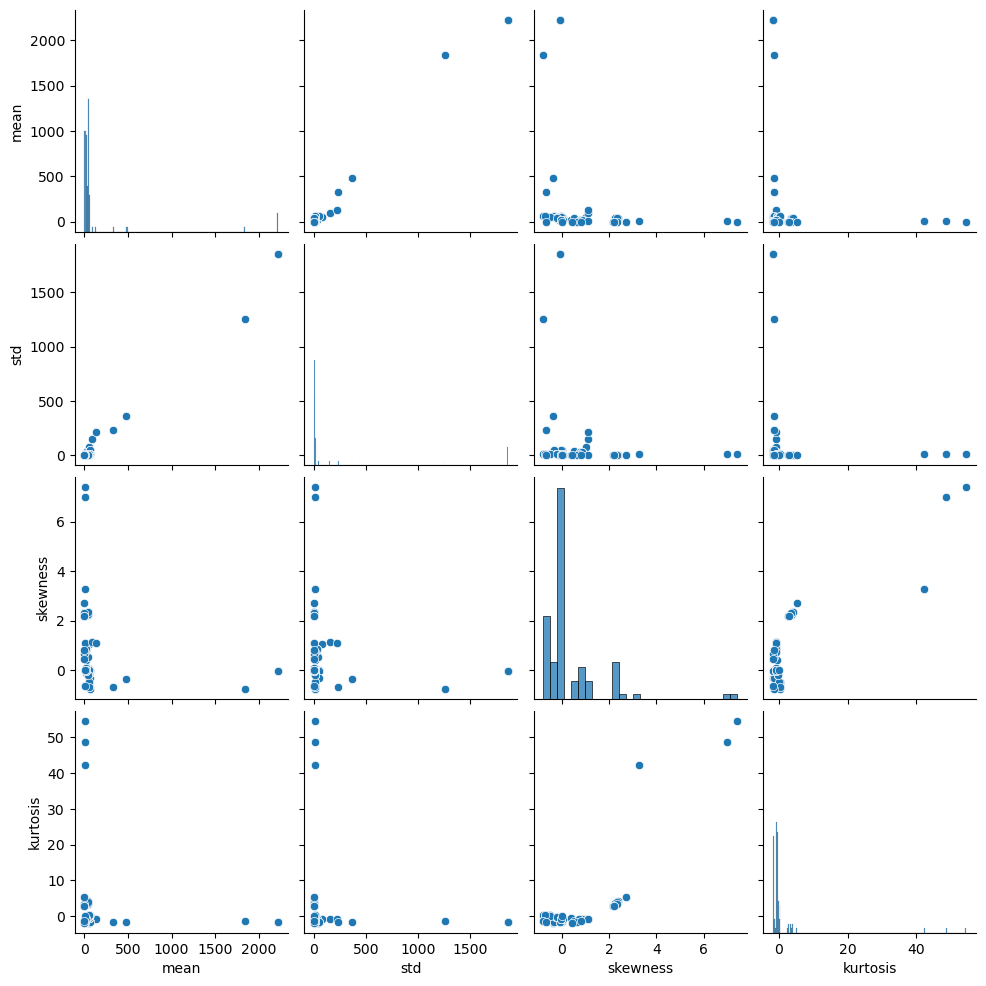

In [38]:

# Create the pairplot for the selected statistics
sns.pairplot(vg5_train_stats[selected_columns], height=2.5)
plt.show()

(99, 205)


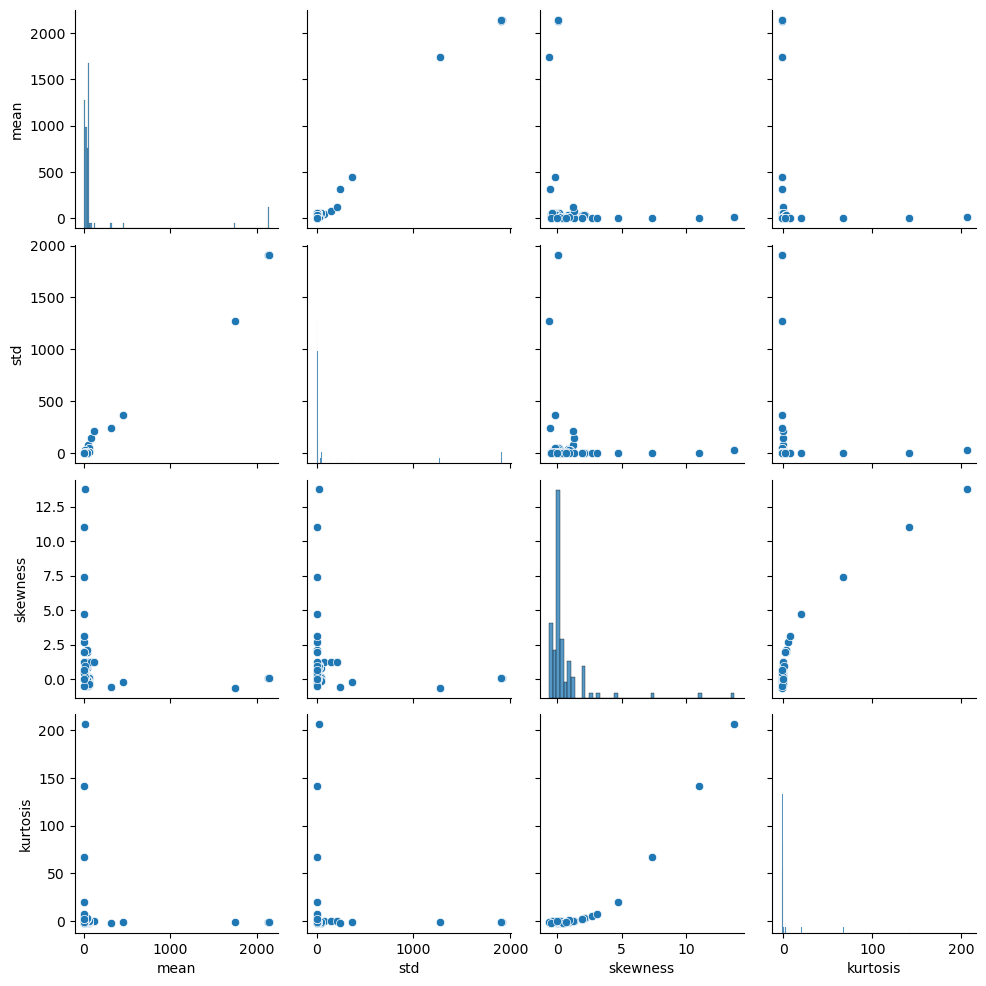

In [39]:
# Downsample the vg5_test_stats DataFrame
vg5_test_stats_downsampled = vg5_test_stats

# Add a 'type' column to the downsampled vg5_test_stats DataFrame to avoid errors in pairplot
vg5_test_stats_downsampled['type'] = 'test'

print(vg5_test_stats_downsampled.shape)
# Create the pairplot for the selected statistics of the test dataset
sns.pairplot(vg5_test_stats_downsampled[selected_columns], height=2.5)
plt.show()

In [40]:

# # Create the pairplot with numeric columns only for the downsampled VG5 train set
# sns.pairplot(vg5_train_stats_downsampled, 
#              vars=selected_columns,
#              height=3, 
#              plot_kws={"alpha": 0.4, "s": 40, "edgecolor": None})


(99, 6)
(99, 6)


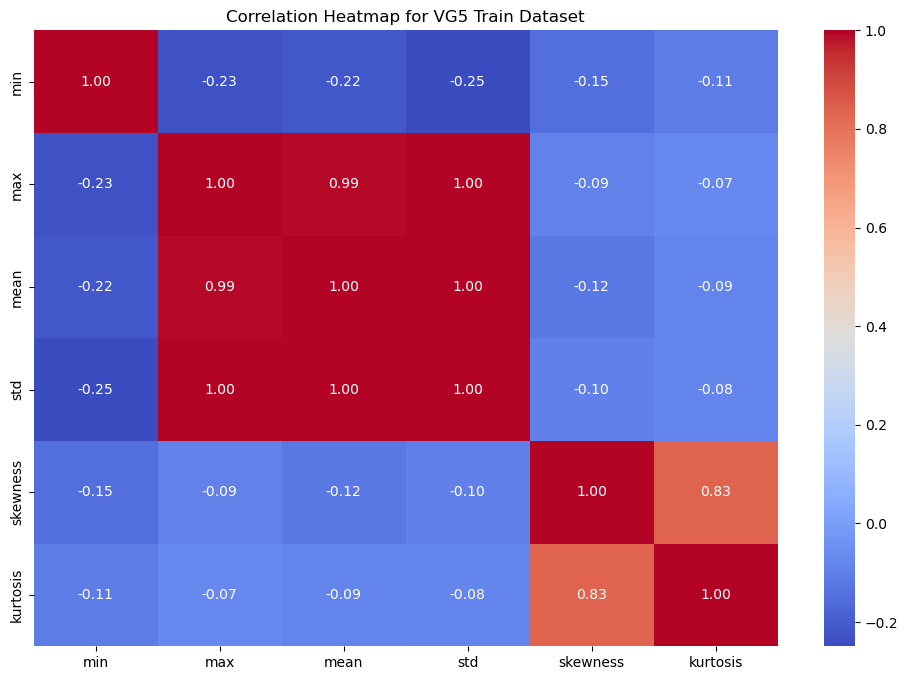

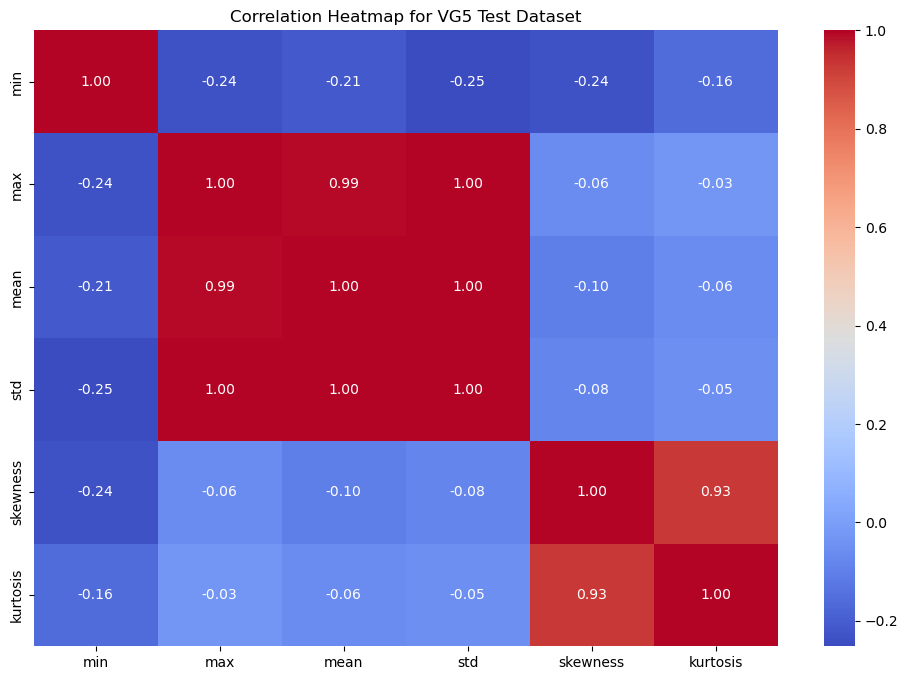

In [41]:
# Filter the DataFrames to keep only the selected columns
vg5_train_stats_downsampled = vg5_train_stats_downsampled[selected_columns]
vg5_test_stats_downsampled = vg5_test_stats_downsampled[selected_columns]

# Print the shapes to verify
print(vg5_train_stats_downsampled.shape)
print(vg5_test_stats_downsampled.shape)

# Compute the correlation matrices
train_corr_matrix = vg5_train_stats_downsampled.corr()
test_corr_matrix = vg5_test_stats_downsampled.corr()

# Plot the heatmap for the train dataset
plt.figure(figsize=(12, 8))
sns.heatmap(train_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap for VG5 Train Dataset")
plt.show()

# Plot the heatmap for the test dataset
plt.figure(figsize=(12, 8))
sns.heatmap(test_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap for VG5 Test Dataset")
plt.show()

In [42]:

# # Downsample the vg5_train_stats DataFrame
# vg5_test_stats_downsampled = vg5_test_stats[::10000]

# # Add a 'type' column to the downsampled vg5_train_stats DataFrame to avoid errors in pairplot
# vg5_test_stats_downsampled['type'] = 'test'



# # Create a pairplot for the downsampled VG5 train set
# sns.pairplot(
#     vg5_test_stats_downsampled,
#     vars=[c for c in vg5_test_stats_downsampled.columns if c != "type"],
#     height=3,
#     plot_kws={"alpha": 0.3, "s": 10, "edgecolor": None}, # original alpha=0.4, s=40, edgecolor=None
#     # diag_kind='hist',  # Uncomment these lines if working on macOS
#     # diag_kws={'alpha': 0.4, 'log': True, 'density': True}
# )

In [43]:
print(selected_columns)

['min', 'max', 'mean', 'std', 'skewness', 'kurtosis']


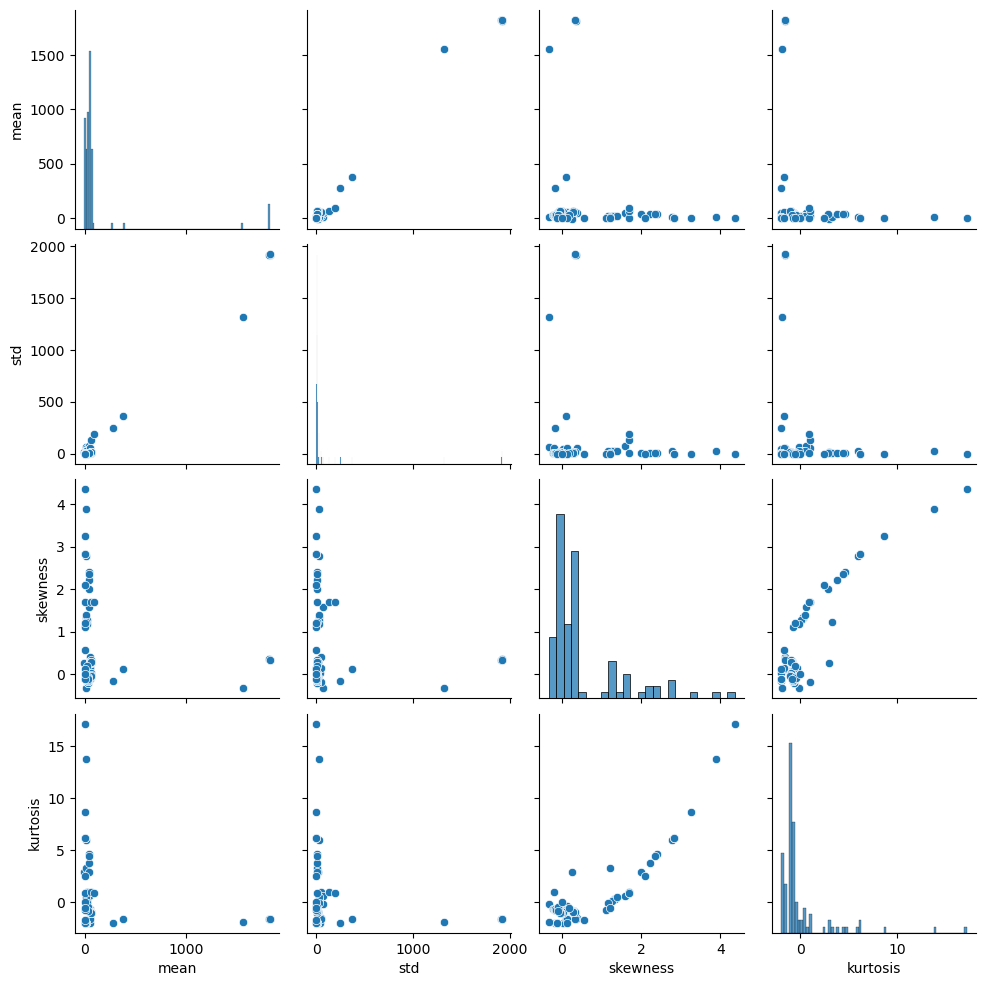

In [44]:
# Load the synthetic anomalies data for VG5 anomaly 01 type a
anomaly_file_path = dataset_root / "synthetic_anomalies/VG5_anomaly_01_type_a.parquet"
if anomaly_file_path.exists():
	vg5_anomaly_01_type_a_measurements = pq.read_table(anomaly_file_path).to_pandas()

	# Compute statistics for the synthetic anomalies data
	vg5_anomaly_01_type_a_stats = compute_statistics(vg5_anomaly_01_type_a_measurements[::1000])

	# Create the pairplot for the selected statistics of the anomalies of type 01
	sns.pairplot(vg5_anomaly_01_type_a_stats[selected_columns], height=2.5)
	plt.show()
else:
	print(f"File not found: {anomaly_file_path}")

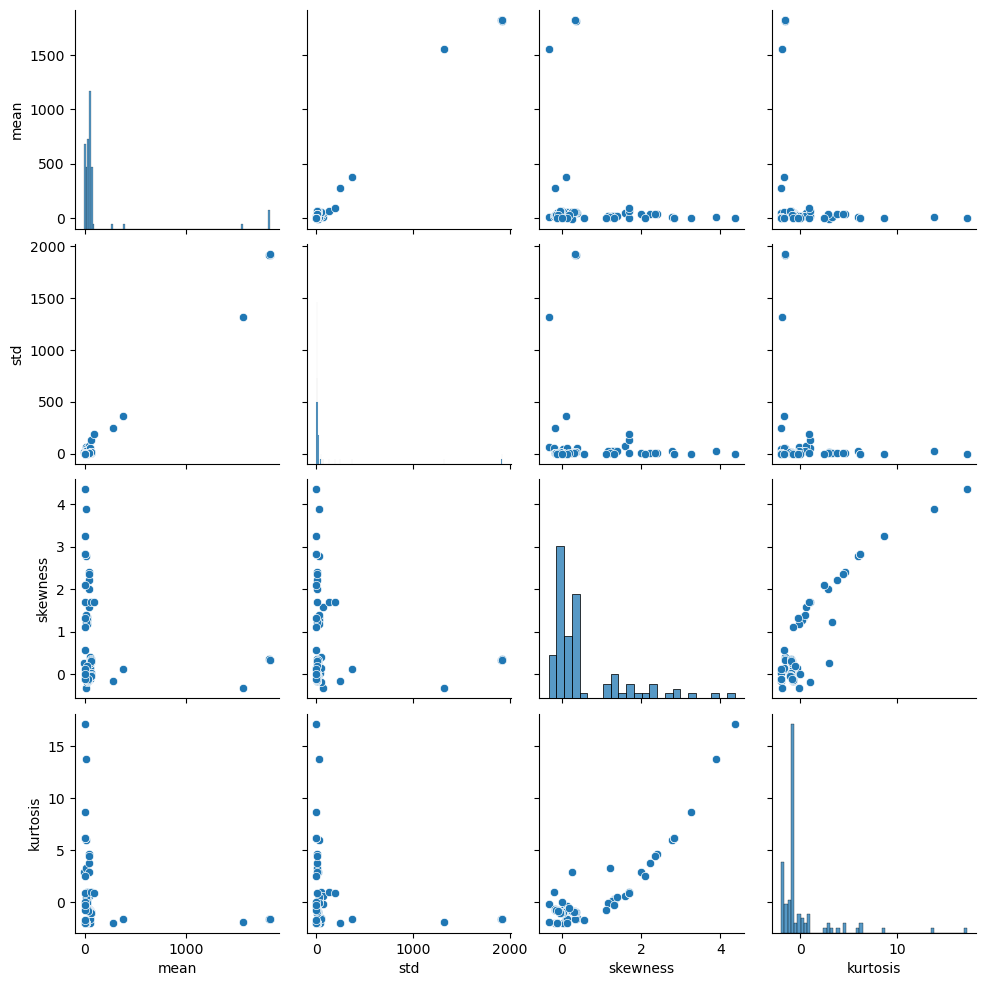

In [45]:
# Load the synthetic anomalies data for VG5 anomaly 01 type a
anomaly_file_path = dataset_root / "synthetic_anomalies/VG5_anomaly_01_type_b.parquet"
if anomaly_file_path.exists():
	vg5_anomaly_01_type_b_measurements = pq.read_table(anomaly_file_path).to_pandas()

	# Compute statistics for the synthetic anomalies data
	vg5_anomaly_01_type_b_stats = compute_statistics(vg5_anomaly_01_type_b_measurements[::1000])

	# Create the pairplot for the selected statistics of the anomalies of type 01
	sns.pairplot(vg5_anomaly_01_type_b_stats[selected_columns], height=2.5)
	plt.show()
else:
	print(f"File not found: {anomaly_file_path}")

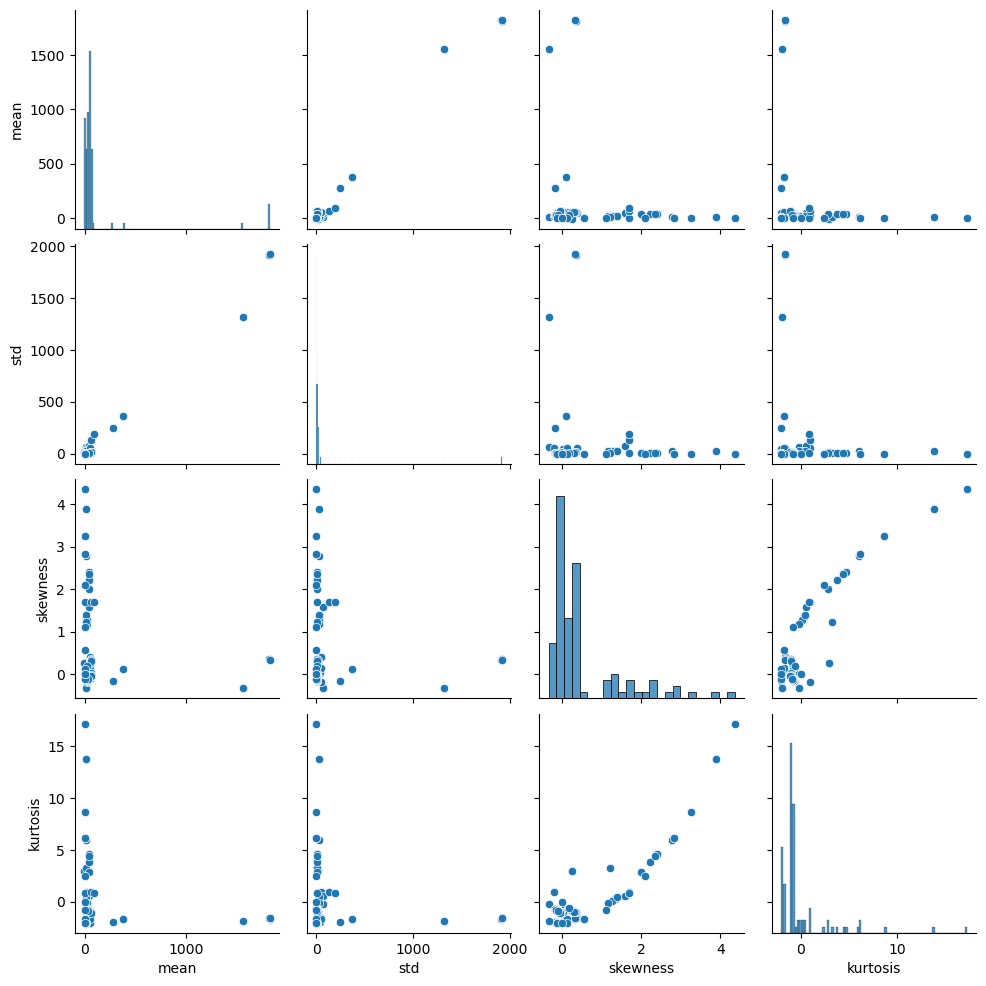

In [46]:
# Load the synthetic anomalies data for VG5 anomaly 01 type a
anomaly_file_path = dataset_root / "synthetic_anomalies/VG5_anomaly_01_type_c.parquet"
if anomaly_file_path.exists():
	vg5_anomaly_01_type_c_measurements = pq.read_table(anomaly_file_path).to_pandas()

	# Compute statistics for the synthetic anomalies data
	vg5_anomaly_01_type_c_stats = compute_statistics(vg5_anomaly_01_type_c_measurements[::1000])

	# Create the pairplot for the selected statistics of the anomalies of type 01
	sns.pairplot(vg5_anomaly_01_type_c_stats[selected_columns], height=2.5)
	plt.show()
else:
	print(f"File not found: {anomaly_file_path}")

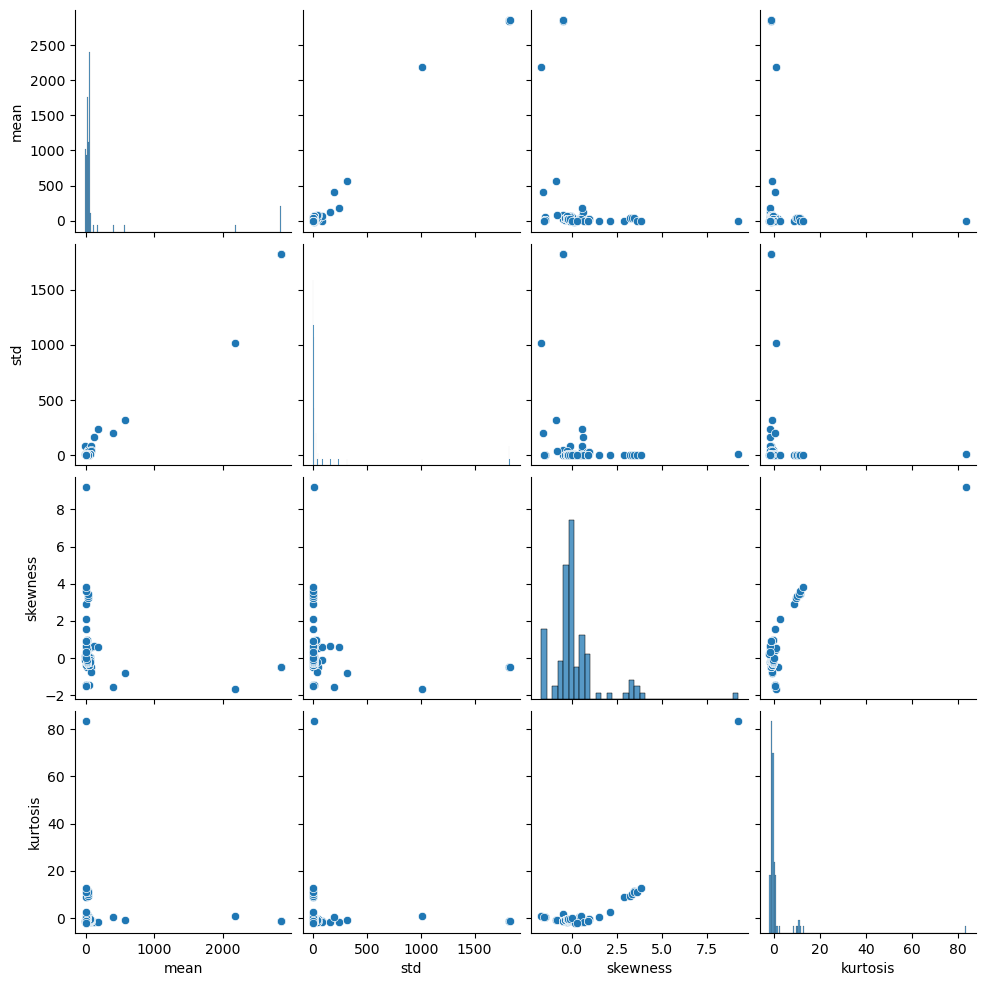

In [47]:
# Load the synthetic anomalies data for VG5 anomaly 02 type c
anomaly_file_path = dataset_root / "synthetic_anomalies/VG5_anomaly_02_type_c.parquet"
if anomaly_file_path.exists():
	vg5_anomaly_02_type_c_measurements = pq.read_table(anomaly_file_path).to_pandas()

	# Compute statistics for the synthetic anomalies data
	vg5_anomaly_02_type_c_stats = compute_statistics(vg5_anomaly_02_type_c_measurements[::1000])

	# Create the pairplot for the selected statistics of the anomalies of type 01
	sns.pairplot(vg5_anomaly_02_type_c_stats[selected_columns], height=2.5)
	plt.show()
else:
	print(f"File not found: {anomaly_file_path}")

## Unsupervised learning approach

Now, let's have a look at if we can use basic unsupervised learning methods (for now, just isolation forest and one-class SVM using PCA features) to predict anomalies.

In [124]:
# Extract the measurement data
measurements_vg5 = rds_u5.data_dict["train"].measurements

# Standardize the features
scaler = StandardScaler()
measurements_vg5_scaled = scaler.fit_transform(measurements_vg5)

In [140]:
measurements_vg5 = rds_u5.data_dict["anomaly_01_type_a"].measurements
measurements_vg5

,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,injector_01_opening,injector_02_opening,injector_03_opening,injector_04_opening,injector_05_opening,...,machine_off,turbine_mode,all,equilibrium_turbine_mode,dyn_only_on,pump_mode,short_circuit_mode,equilibrium_pump_mode,equilibrium_short_circuit_mode,ground_truth
2021-06-01 00:00:00+02:00,68.560318,16.231133,16.937216,69.486435,9.034166,0.000000,61.281322,61.150532,0.0,61.425194,...,False,True,True,False,True,False,False,False,False,0.0
2021-06-01 00:00:30+02:00,71.174561,16.183379,16.928701,70.857573,9.033857,38.503090,42.735943,42.796980,0.0,42.916000,...,False,True,True,False,True,False,False,False,False,0.0
2021-06-01 00:01:00+02:00,73.023515,16.135625,16.920185,71.803329,9.033549,43.150226,43.049576,43.215415,0.0,43.024339,...,False,True,True,False,True,False,False,False,False,0.0
2021-06-01 00:01:30+02:00,73.649020,16.087871,16.911669,72.867161,9.033240,43.920042,44.130617,43.877318,0.0,43.879353,...,False,True,True,False,True,False,False,False,False,0.0
2021-06-01 00:02:00+02:00,76.121750,16.040118,16.903154,73.484650,9.032931,45.404236,45.356425,45.370260,0.0,45.472580,...,False,True,True,False,True,False,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-30 23:58:00+02:00,0.000000,23.435252,19.410579,4.540089,9.083500,0.000000,0.000000,0.000000,0.0,0.000000,...,True,False,True,False,False,False,False,False,False,0.0
2021-07-30 23:58:30+02:00,0.000000,23.426828,19.410112,4.385781,9.083500,0.000000,0.000000,0.000000,0.0,0.000000,...,True,False,True,False,False,False,False,False,False,0.0
2021-07-30 23:59:00+02:00,0.000000,23.418405,19.409645,4.627991,9.083500,0.000000,0.000000,0.000000,0.0,0.000000,...,True,False,True,False,False,False,False,False,False,0.0
2021-07-30 23:59:30+02:00,0.000000,23.409981,19.409178,4.400494,9.083500,0.000000,0.000000,0.000000,0.0,0.000000,...,True,False,True,False,False,False,False,False,False,0.0


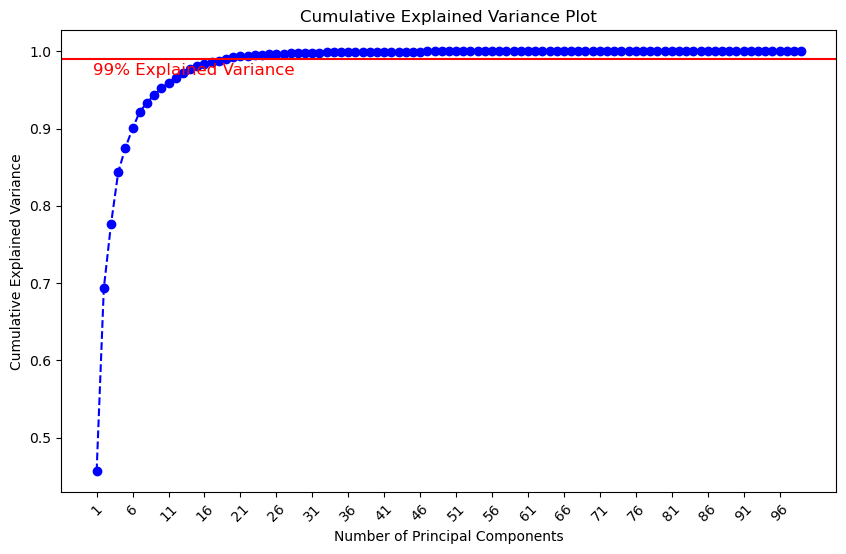

In [125]:
pca = PCA()
pca.fit(measurements_vg5_scaled)

# Calculate explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker='o',
    linestyle='--',
    color='b',
)
plt.title('Cumulative Explained Variance Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')

# Adjust x-axis ticks
plt.xticks(ticks=range(1, len(cumulative_explained_variance) + 1, 5), rotation=45)  # Display every 5th tick for readability
plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.97, '99% Explained Variance', color='red', fontsize=12)
plt.show()

In [126]:
# Determine the number of components to explain 90% of the variance
desired_variance = 0.99
n_components = np.argmax(cumulative_explained_variance >= desired_variance) + 1
print(f"Number of components to explain {desired_variance*100}% variance: {n_components}")

Number of components to explain 99.0% variance: 19


In [127]:
# Apply PCA
n_components = 19
pca = PCA(n_components=n_components)  # Choose the number of components, e.g., based on explained variance
pca_features_vg5_train = pca.fit_transform(measurements_vg5_scaled)

Now that we have PCA with our main features for the synthetic dataset, let's evaluate how different models perform on the test dataset with synthetic anomalies.

In [141]:
# Train Isolation Forest on PCA features
iso_forest = IsolationForest(contamination=0.1, random_state=42)  # Set contamination level based on expected anomaly rate
iso_forest.fit(pca_features_vg5_train)

IsolationForest(contamination=0.1, random_state=42)

In [142]:
synthetic_anomaly_01_type_a_vg5 = rds_u5.data_dict["anomaly_01_type_a"].measurements

In [143]:
anomaly_types = ['a', 'b', 'c']

# Dictionaries to store evaluation metrics and confusion matrices
results = {}
confusion_matrices = {}

# Loop through each anomaly type and store results
for anomaly_type in anomaly_types:
    # Access the measurements and ground truth for the current anomaly type
    anomaly_key = f"anomaly_01_type_{anomaly_type}"
    if anomaly_key in rds_u5.data_dict:
        synthetic_anomaly = rds_u5.data_dict[anomaly_key].measurements

        # Separate features and labels
        X_anomaly = synthetic_anomaly.drop(columns=['ground_truth'])
        y_anomaly = synthetic_anomaly['ground_truth']

        # Standardize using the same scaler fitted on the training data
        X_anomaly_scaled = scaler.transform(X_anomaly)

        # Apply PCA transformation using the same PCA model
        X_anomaly_pca = pca.transform(X_anomaly_scaled)

        # Predict anomalies
        predictions_anomaly = iso_forest.predict(X_anomaly_pca)

        # Convert predictions to match ground truth labels
        y_pred = np.where(predictions_anomaly == 1, 0, 1)

        # Calculate evaluation metrics and store in the results dictionary
        results[anomaly_type] = {
            "accuracy": accuracy_score(y_anomaly, y_pred),
            "precision": precision_score(y_anomaly, y_pred),
            "recall": recall_score(y_anomaly, y_pred),
            "f1": f1_score(y_anomaly, y_pred),
            "classification_report": classification_report(y_anomaly, y_pred, output_dict=True)
        }

        # Compute and store confusion matrix
        confusion_matrices[anomaly_type] = confusion_matrix(y_anomaly, y_pred)
    else:
        print(f"Anomaly type '{anomaly_type}' not found in the dataset.")

In [145]:
results["a"]

{'accuracy': 0.7677376403843927,
 'precision': 0.5569744873561925,
 'recall': 0.4482703975369012,
 'f1': 0.49674497949148927,
 'classification_report': {'0.0': {'precision': 0.8223545619546757,
   'recall': 0.8774967332462199,
   'f1-score': 0.8490312578784379,
   'support': 128568.0},
  '1.0': {'precision': 0.5569744873561925,
   'recall': 0.4482703975369012,
   'f1-score': 0.49674497949148927,
   'support': 44172.0},
  'accuracy': 0.7677376403843927,
  'macro avg': {'precision': 0.689664524655434,
   'recall': 0.6628835653915606,
   'f1-score': 0.6728881186849636,
   'support': 172740.0},
  'weighted avg': {'precision': 0.7544932174185857,
   'recall': 0.7677376403843927,
   'f1-score': 0.7589467986396496,
   'support': 172740.0}}}

In [131]:
# Separate features and labels
X_anomaly = synthetic_anomaly_01_type_a_vg5.drop(columns=['ground_truth'])
y_anomaly = synthetic_anomaly_01_type_a_vg5['ground_truth']

# Standardize using the same scaler fitted on the training data
X_anomaly_scaled = scaler.transform(X_anomaly)

# Apply PCA transformation using the same PCA model
X_anomaly_pca = pca.transform(X_anomaly_scaled)

In [ ]:
# Count anomalies in the synthetic dataset
total_samples = len(y_anomaly)
num_anomalies = y_anomaly.sum()
anomaly_rate = num_anomalies / total_samples

print(f"Total samples: {total_samples}")
print(f"Number of anomalies: {num_anomalies}")
print(f"Anomaly rate: {anomaly_rate:.2%}")

In [119]:
# Predict anomalies
predictions_anomaly = iso_forest.predict(X_anomaly_pca)

# Convert predictions to match ground truth labels
# Isolation Forest outputs: 1 (normal), -1 (anomaly)
# We need to map this to: 0 (normal), 1 (anomaly)
y_pred = np.where(predictions_anomaly == 1, 0, 1)

In [120]:
# Calculate various evaluation metrics
accuracy = accuracy_score(y_anomaly, y_pred)
precision = precision_score(y_anomaly, y_pred)
recall = recall_score(y_anomaly, y_pred)
f1 = f1_score(y_anomaly, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display a full classification report
print("\nClassification Report:")
print(classification_report(y_anomaly, y_pred))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_anomaly, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Accuracy: 0.9010
Precision: 0.7385
Recall: 0.9488
F1 Score: 0.8305

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93    128568
         1.0       0.74      0.95      0.83     44172

    accuracy                           0.90    172740
   macro avg       0.86      0.92      0.88    172740
weighted avg       0.92      0.90      0.90    172740


Confusion Matrix:
[[113724  14844]
 [  2261  41911]]
